## Setup

In [1]:
import mpi4py

import numpy as np
import matplotlib.pyplot as plt
import pickle

from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya, loadMCSamples
from getdist import gaussian_mixtures
import getdist.plots as gdplt

import matplotlib
from matplotlib.lines import Line2D

from sympy import symbols, diff, lambdify

from itertools import combinations

%matplotlib inline

plt.rcParams.update({"text.usetex": True,"font.family": "serif"})
myColors = ['C1', 'C2', 'C4', 'C3']
gdplot = gdplt.get_subplot_plotter()

### Params

In [2]:
tau_prior = 0.6

slurm_id= 38323256 #38322571
job = f'BBN_paper3'

dfbn = 'BBN_paper3'
data_file_base=f'data_files/{dfbn}'
save_name=f'BBN3_t{tau_prior}'

#### const params

In [3]:

gparams = ['eta10', 'N_nu', 'tau']
removeParams = []
fixedParams = {}

experiment = 0
spectrum = 'unlensed'
useDali = True
save_pdf = True
cobaya_debug = False

inc_base='/users/stevensonb/scratch/tmp/chains/incomplete'
fin_base='/users/stevensonb/Research/DALI/chains'

latex_trans = {
    'omega_c_h2':r'\Omega_\mathrm{cdm}h^2', 
    'omega_b_h2':r'\Omega_b h^2', 
    'N_eff':r'N_\nu',
    'N_nu':r'N_\nu', # Just for the effect
    'A_s':r'A_\mathrm{s}', 
    'n_s':r'n_\mathrm{s}', 
    'theta_s':r'\theta_\mathrm{s}',
    'tau':r'\tau_n\;[s]',
    'mnu':r'm_\mathrm{\nu}',
    'eta10':r'\eta_\mathrm{10}'
}

i = 0 if tau_prior == 0.6 else tau_prior
import os
if os.path.exists(f'{fin_base}/complete/{job}/{slurm_id}/{i}/'):
    exact_chain_path = f'{fin_base}/complete/{job}/{slurm_id}/{i}/{i}'
elif os.path.exists(f'{inc_base}/{job}/{slurm_id}/{i}/'):
    exact_chain_path=f'{inc_base}/{job}/{slurm_id}/{i}/{i}'
else:
    print(f'Could not find chain for {job} {slurm_id} {i}')

## Functions

Main data processing functions

In [4]:
def get_data(dfile=f'{data_file_base}.pkl', fixed_params=fixedParams, prior=tau_prior):
    params = {}
    with open(dfile, 'rb') as f:
        data = pickle.load(f)
        fid = data['cosmoFid']
        fisher = data['nfisherGaussian'][experiment][spectrum]
        fisher[2,2] += 1/(prior**2)
        
    cov = np.linalg.inv(fisher)
    
    widths = {'eta10': 3, 'N_nu': 3, 'tau': 200}
    for i, (k, v) in enumerate(fid.items()):
        if k not in fixed_params:
            val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'min': max(v-widths[k],0), 'max':v+widths[k]}}
            params.update({k: val})
        else:
            params.update({k: {'value': fixed_params[k], 'latex': latex_trans.get(k, k)}})
            
    return params, fid, cov

def get_model(data_file=f'{data_file_base}.pkl', fixed_params=fixedParams, prior=tau_prior):
    params, cosmoFid, cov = get_data(data_file, fixed_params, prior=prior)
    
    model = {
        'debug': cobaya_debug,
        'likelihood': {
            'dali': { 
                'python_path': 'likelihoods/dali',
                'file': data_file,
                'tau_prior': prior
            }
        },
        'params': params,
        'sampler': {
            'mcmc': {
                'covmat_params': list(params.keys()),
                'covmat': cov,
                'oversample_power': 0.8,
                'proposal_scale': 1.5,
                'Rminus1_stop': 0.0005,
                'Rminus1_cl_stop': 0.2,
                'max_tries': 1000,
            }
        }
    }
    return model


### Curvature Func

In [5]:
"""
Created on Tuesday, July 26, 2022, at 01:23 PM

@author: Joe Ryan and Cynthia Trendafilova
Modifications by: Brandon Stevenson
"""
def add_KBBN(bounds, 
grid_order = list(combinations(range(0, 3), r=2)), 
plot_order = list(combinations(range(0, 3), r=2)),
contour_levels = [0, 2.3, 6.17], 
data_file = f'{data_file_base}.pkl',
lws=[1, 1, 1],
colors=myColors,
exp=experiment, 
spec=spectrum,
grid_size=16j,
linspace_size=50,
alphas=[0.5,0.5,1],
prior=tau_prior,
):
    """
    Note: girid_order and plot_order must be the same length
    """

    with open(f'{data_file_base}.pkl', 'rb') as f:
        data_BBN = pickle.load(f)
    
    fid = data_BBN['cosmoFid']
    F = data_BBN['nfisherGaussian'][exp][spec]
    F[2,2] += 1/(prior**2)
    G = data_BBN['nDALI3Gaussian'][exp][spec]
    H = data_BBN['nDALI4Gaussian'][exp][spec]
    
    x = symbols('x', real=True)
    y = symbols('y', real=True)

    p_names = list(fid.keys())
    p_fid = list(fid.values())

    for q in range(0, len(plot_order), 1):        
        i = plot_order[q][0]
        j = plot_order[q][1]
        ij = [i, j]
        
        p = [x - p_fid[i], y - p_fid[j]]
        
        sumF = (-1/2)*(F[i][i]*p[0]*p[0] + F[i][j]*p[0]*p[1] + F[j][i]*p[1]*p[0] + F[j][j]*p[1]*p[1])
        sumG = 0
        sumH = 0
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    sumG += (-1/2)*G[ij[a]][ij[b]][ij[c]]*p[a]*p[b]*p[c]
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    for d in range(0, 2, 1):
                        sumH += (-1/8)*H[ij[a]][ij[b]][ij[c]][ij[d]]*p[a]*p[b]*p[c]*p[d]
                        
        Phi = -(sumF + sumG + sumH)
        
        Phi0 = diff(Phi, x)
        Phi1 = diff(Phi, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = np.mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_D = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeD = np.argwhere(K_D <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeD)
    
        ### Sanity check:
        Phi_F = -sumF
        
        Phi0 = diff(Phi_F, x)
        Phi1 = diff(Phi_F, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = np.mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_F = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeF = np.argwhere(K_F <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_Fisher_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeF)
        
        #if len(negativeD) != 0:
        X0 = []
        X1 = []
        
        for u in np.arange(0, len(negativeD), 1):
            I0 = negativeD[u][0]
            I1 = negativeD[u][1]
            
            X0.append(x0[I0][I1])
            X1.append(x1[I0][I1])
            
        ### Save coordinates:
        # savetxt('coords_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', c_[X0, X1])
    
        ### Plot coordinates at which K <= 0 over Fisher and Doublet cross-section contours:
       
        X = np.linspace(bounds[i][0], bounds[i][1], linspace_size)
        Y = np.linspace(bounds[j][0], bounds[j][1], linspace_size)
        
        Z = []
        Z_F = []
        xl = []
        yl = []
        
        Phi_L = lambdify([x, y], Phi)
        Phi_FL = lambdify([x, y], Phi_F)
        for xc0 in X:
            for xc1 in Y:
                Z.append(Phi_L(xc0, xc1))
                Z_F.append(Phi_FL(xc0, xc1))
                xl.append(xc0)
                yl.append(xc1)    

        x_2d = np.reshape(xl, (linspace_size, linspace_size))
        y_2d = np.reshape(yl, (linspace_size, linspace_size))
        z_2d = np.reshape(Z, (linspace_size, linspace_size))
        zf_2d = np.reshape(Z_F, (linspace_size, linspace_size))

        # print(gdplot.fig.get_axes())
        # ax = gdplot.fig.get_axes()[grid_order[q][0]][grid_order[q][1]]
        ax = gdplot.get_axes(grid_order[q])
        
        # set labels in accordance with plotter style
        lab_fontsize = gdplot._scaled_fontsize(gdplot.settings.axes_labelsize)
        ax.set_xlabel('$'+latex_trans.get(p_names[i], p_names[i])+'$',  fontsize=lab_fontsize, verticalalignment='baseline', labelpad=4 + lab_fontsize)
        ax.set_ylabel('$'+latex_trans.get(p_names[j] , p_names[j])+'$', fontsize=lab_fontsize)

        tick_label_size = gdplot._scaled_fontsize(None, gdplot.settings.axes_fontsize)
        ax.tick_params(which='major', labelsize=tick_label_size)
        # ax.get_offset_text().set_fontsize(tick_label_size * 3 / 4 if tick_label_size > 7 else tick_label_size)

        ax.set_xlim(bounds[i][0], bounds[i][1])
        ax.set_ylim(bounds[j][0], bounds[j][1])
        
        ax.scatter(X0, X1, marker='.', color=colors[3], zorder=1, label='Concavity', alpha=alphas[0])
        ax.contour(x_2d, y_2d, z_2d, contour_levels, colors=colors[1], linestyles='dashed', zorder=3, linewidths=lws[1], alpha=alphas[1]).collections[0].set_label('Doublet')
        ax.contour(x_2d, y_2d, zf_2d, contour_levels, colors=colors[2], linestyles='dotted', zorder=2, linewidths=lws[2], alpha=alphas[2]).collections[0].set_label('Fisher')

## Progress Report

In [6]:
# from cobaya.samplers.mcmc import plot_progress

# id=slurm_id
# chain_loc=f'{inc_base}/{job}/{id}'
# for i in [0,1,5,10,15,30]:
#     path = f'{chain_loc}/{i}'
#     if os.path.exists(path):
#         plot_progress(f'{path}/{i}')
#         plt.title(f'Chain {i}')
#         plt.tight_layout()
#         plt.show()
#     else:
#         print(f'Chain {i} does not exist at {path}')

## Analysis

### Generator

In [7]:
gdsExact = loadMCSamples(exact_chain_path)
gdsExact.name_tag = 'Exact'

with open(f'{data_file_base}.pkl', 'rb') as f: 
    data = pickle.load(f)  
    fid = data['cosmoFid']
    fisher = data['nfisherGaussian'][experiment][spectrum]
    fisher[2,2] += 1/(tau_prior**2)
    inv = np.linalg.inv(fisher)
aFisher = gaussian_mixtures.GaussianND(list(fid.values()), inv, label='Fisher', names=list(fid.keys()), labels=[f'${latex_trans.get(k, k)}$' for k in fid.keys()])

updatedDali, samplerDali = run(get_model())
gdsDali = MCSamplesFromCobaya(updatedDali, samplerDali.products()["sample"], name_tag='DALI')


[dali] tau_prior: 0.6
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 3880.0}
[mcmc] Covariance matrix loaded for params ['eta10', 'N_nu', 'tau']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: eta10:6.123, N_nu:3, tau:879.4
[mcmc] Sampling!
[mcmc] Progress @ 2022-11-08 17:20:37 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.407
[mcmc]  - Convergence of means: R-1 = 0.402296 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.472
[mcmc]  - Convergence of means: R-1 = 0.378241 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 360 samples accepted.
[mcmc]  - Acceptance rate: 0.459
[mcmc]  - Conve

### Solo Plotter

In [8]:
# gdplot.triangle_plot(gdsExact, gparams, label='a', filled=True, colors=myColors, contour_colors=myColors)
# gdplot.triangle_plot(aFisher, gparams, filled=True, colors=myColors, contour_colors=myColors)
# gdplot.triangle_plot(gdsDali, gparams, filled=True, colors=myColors, contour_colors=myColors)

### Finalize

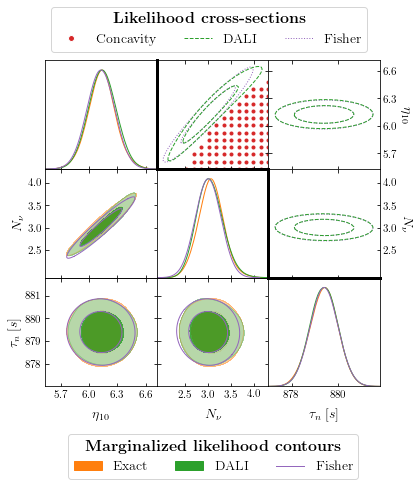

In [9]:
gds = gdplt.GetDistPlotSettings()
gds.fontsize=14
# gds.axes_labelsize = 14
# gds.axes_fontsize = 14
gds.legend_fontsize=14
gds.legend_frac_subplot_margin=1
gds.scaling=False
gds.tight_layout=False

gdplot = gdplt.get_subplot_plotter(settings=gds)

gdplot.triangle_plot([gdsExact, gdsDali, aFisher], 
                     gparams, 
                     filled=[True, True, False], 
                     colors=myColors, 
                     contour_colors=myColors, 
                     legend_ncol=3)

xbounds = [gdplot.get_axes((0,0)).get_xlim(), gdplot.get_axes((1,1)).get_xlim(), gdplot.get_axes((2,2)).get_xlim()]
add_KBBN(bounds=xbounds, 
         plot_order=[[1,0], [2,0], [2,1]], 
         contour_levels = [0, 2.3, 6.17], 
         lws=[1,1,1], 
         alphas=[1, 1, 1])

#Clean up time
a = gdplot.get_axes((0,1))
b = gdplot.get_axes((0,2))
c = gdplot.get_axes((1,2))

# add bars to seperate the curvature from posteriors
bar_thickness = 3.0
a.spines['left'].set_linewidth(bar_thickness)
a.spines['bottom'].set_linewidth(bar_thickness)
c.spines['left'].set_linewidth(bar_thickness)
c.spines['bottom'].set_linewidth(bar_thickness)

#fix ticks and labels
a.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = False, top=True, bottom=True, left=False, right=True)
b.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=True, right=True)
c.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=False, right=True)

# a.get_xaxis().set_label_position('top')
a.get_yaxis().set_label_position('right')
a.set_xlabel('')
# b.get_xaxis().set_label_position("top")
b.get_yaxis().set_label_position("right")
b.set_ylabel(b.get_ylabel(), rotation=270, labelpad=16)
c.get_yaxis().set_label_position("right")
c.set_ylabel(c.get_ylabel(), rotation=270, labelpad=16)
c.set_xlabel('')

#fix the tick labels
a.set_xticks(gdplot.get_axes((1,1)).get_xticks())
b.set_xticks(gdplot.get_axes((2,2)).get_xticks())
c.set_xticks(gdplot.get_axes((2,2)).get_xticks())

a.set_yticks(gdplot.get_axes((0,0)).get_xticks())
b.set_yticks(gdplot.get_axes((0,0)).get_xticks())
c.set_yticks(gdplot.get_axes((1,1)).get_xticks())

# legends
gdplot.legend.set_bbox_to_anchor((0.85, 0.015), transform=gdplot.fig.transFigure)
gdplot.legend.set_title(r'$\textbf{Marginalized likelihood contours}$')
gdplot.legend.get_title().set_fontsize(16)

legend_elements_upper = [Line2D([0], [0], marker='o', color='w', markersize=6, label = 'Concavity', markerfacecolor=myColors[3]),
                         Line2D([0], [0], color=myColors[1], lw=1, label = 'DALI', linestyle='dashed'),
                         Line2D([0], [0], color=myColors[2], lw=1, label = 'Fisher', linestyle='dotted')]
myTitleFont = matplotlib.font_manager.FontProperties(weight='bold',size=16)
legend2 = gdplot.fig.legend(handles=legend_elements_upper, fontsize=14, ncol=3,\
             bbox_to_anchor=(0.505,0.9), loc='lower center', borderaxespad=0)
legend2.set_title(r'\textbf{Likelihood cross-sections}',prop=myTitleFont)

# for col in c.legend_elements():
#       print(col)
# legend2 = c.legend(ncol=3, bbox_to_anchor=(0.8, 1.065), bbox_transform=gdplot.fig.transFigure)
# legend2.set_title(r'$\textbf{Likelihood cross-sections}$')

# fix overlapping of curvature points on some borders
for ax in [a,b,c]:
    for k, spine in ax.spines.items():
        spine.set_zorder(10)
        
if save_pdf:
    # export wasn't adjusting overall figure size to fit the curvature legend, so we do it manually
    # gdplot.export(job + '.pdf')
    gdplot.fig.savefig(f'{save_name}.pdf', bbox_extra_artists=gdplot.extra_artists + [legend2], bbox_inches='tight')